In [1]:
import ast
from typing import Union, Tuple, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.signal import butter, filtfilt

In [ ]:
# Load datasets
df2 = pd.read_csv(r"C:\Users\pasupuleti\Desktop\group-project\experiments\drowsiness_data\lloyd_1\session_metrics.csv")
df1 = pd.read_csv(r"C:\Users\pasupuleti\Desktop\group-project\experiments\drowsiness_data\Prof_ignacio1\session_metrics.csv")
df3 = pd.read_csv(r"C:\Users\pasupuleti\Desktop\group-project\experiments\drowsiness_data\devano_palma\session_metrics.csv")

In [3]:
df3 = df3[1:-1]  # Remove first and last rows of devano_palma dataset

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

def steering_reversal_rate(steering_angle, gap_size=3.0, lowpass_cutoff=0.6, filter_order=2):
    """
    Calculate the Steering Wheel Reversal Rate (SRR) as defined by Markkula & Engström (2006).
    
    Parameters
    ----------
    steering_angle : np.ndarray
        Array of steering wheel angle values (degrees).
    fs : float
        Sampling frequency in Hz.
    gap_size : float, optional
        Minimum angular difference (degrees) between reversals (default 3.0° for visual load).
    lowpass_cutoff : float, optional
        Low-pass filter cutoff frequency (Hz) (default 0.6 Hz).
    filter_order : int, optional
        Butterworth filter order (default 2).
    
    Returns
    -------
    reversal_rate : float
        Steering wheel reversal rate (reversals per minute).
    """
    
    # 1 Low-pass filter to remove noise
    fs = len(steering_angle) / 60.0  # Assuming steering_angle is sampled over 60 seconds
    nyquist = 0.5 * fs
    normal_cutoff = lowpass_cutoff / nyquist
    b, a = butter(filter_order, normal_cutoff, btype='low', analog=False)
    filtered_angle = filtfilt(b, a, steering_angle)
    
    # 2️ Find stationary points (local minima and maxima)
    diff = np.diff(filtered_angle)
    sign_changes = np.sign(diff)
    stationary_idx = np.where(np.diff(sign_changes) != 0)[0] + 1
    
    # 3️ Compute reversals
    reversals = 0
    k = 0
    for l in range(1, len(stationary_idx)):
        theta_k = filtered_angle[stationary_idx[k]]
        theta_l = filtered_angle[stationary_idx[l]]
        delta_theta = theta_l - theta_k
        
        if abs(delta_theta) >= gap_size:
            reversals += 1
            k = l
        elif abs(theta_l) < abs(theta_k):
            k = l
    # 4️ Calculate rate per minute
    duration_min = len(steering_angle) / (fs * 60.0)
    reversal_rate = reversals / duration_min if duration_min > 0 else 0.0
    
    return reversal_rate


def calculate_blink_duration(
    ear_values: np.ndarray, ear_threshold: float
) -> float:
    """
    Calculate the average blink duration (in seconds) from EAR values
    over a fixed 60-second window. Automatically estimates FPS based
    on the total number of frames.

    A blink is defined as any continuous sequence of EAR values below
    the threshold.

    Args:
        ear_values (np.ndarray): Array of EAR values over a 60-second window.
        ear_threshold (float): EAR threshold below which eyes are considered closed.

    Returns:
        float: Average blink duration (seconds). Returns 0.0 if no blinks detected.
    """
    if len(ear_values) == 0:
        return 0.0

    # --- Estimate FPS based on 60-second window ---
    total_frames = np.sum([ear is not None for ear in ear_values])
    if total_frames == 0:
        return 0.0
    fps = total_frames / 60.0  # frames per second

    # --- Detect blinks ---
    blink_durations = []
    consec_count = 0

    for ear in ear_values:
        if ear is not None:
            if ear < ear_threshold:
                consec_count += 1
            else:
                if consec_count > 0:
                    blink_durations.append(consec_count / fps)
                    consec_count = 0
        else:
            if consec_count > 0:
                blink_durations.append(consec_count / fps)
                consec_count = 0

    # Handle blink ending at the final frame
    if consec_count > 0:
        blink_durations.append(consec_count / fps)

    if len(blink_durations) == 0:
        return 0.0

    return float(np.mean(blink_durations))



def calculate_perclos(
    ear_values: np.ndarray, ear_threshold: float, min_consec_frames: int
) -> float:
    """
    Calculate PERCLOS (Percentage of Eye Closure) from stored EAR values.

    Args:
        ear_values (np.ndarray): Array of EAR values sampled over time.
        ear_threshold (float): EAR threshold below which eyes are considered closed.
        min_consec_frames (int): Minimum consecutive frames below threshold to count as closed.

    Returns:
        float: PERCLOS percentage over the EAR values window.
    """
    closed_frames = 0
    consec_count = 0

    for ear in ear_values:
        if ear is not None:  # frames with no mediapipe mesh records aa none
            if ear < ear_threshold:  # eye closed
                consec_count += 1
            else:
                if consec_count >= min_consec_frames:  # eye opened
                    closed_frames += (
                        consec_count  # add the consecutive frames to closed frames
                    )
                consec_count = 0  # restart the count

    # Account for closing at the end of the window
    if consec_count >= min_consec_frames:
        closed_frames += consec_count

    total_frames = np.sum([ear is not None for ear in ear_values])

    if total_frames == 0:
        return 0.0

    perclos = (closed_frames / total_frames) * 100.0
    return perclos



def approx_entropy(time_series: np.array, run_length: int = 2) -> float:
    """Approximate entropy (2sec window) [https://www.mdpi.com/1424-8220/17/3/495]

    Args:
        time_series (np.array): steering movement data
        run_length (int): length of the run data (window with overlapping of the data,
        example x = [1,2,3], if runlength=2 then output will be [[1,2], [2,3]])

    Returns:
        float: regularity (close to 0 : no irregularity, close to 1: irregularity)
    """
    std_dev = np.std(time_series)
    filter_level = 0.2 * std_dev

    def _maxdist(x_i, x_j):
        return max(abs(ua - va) for ua, va in zip(x_i, x_j))

    def _phi(m):
        n = time_series_length - m + 1
        x = [
            [time_series[j] for j in range(i, i + m - 1 + 1)]
            for i in range(time_series_length - m + 1)
        ]
        counts = [
            sum(1 for x_j in x if _maxdist(x_i, x_j) <= filter_level) / n for x_i in x
        ]
        return sum(math.log(c) for c in counts) / n

    time_series_length = len(time_series)

    return abs(_phi(run_length + 1) - _phi(run_length))


def approx_entropy_fast(time_series: np.ndarray, m: int = 2, r: float = None) -> float:
    """
    Fast Approximate Entropy (ApEn) computation.
    Based on Pincus (1991) and same logic as your code, but vectorized.

    Parameters
    ----------
    time_series : np.ndarray
        Input steering angle (or other) time series.
    m : int, optional
        Embedding dimension (run length). Default = 2.
    r : float, optional
        Tolerance threshold. Default = 0.2 * std(time_series).

    Returns
    -------
    float
        Approximate entropy value (0 → regular, 1 → irregular)
    """
    x = np.asarray(time_series, dtype=float)
    n = len(x)

    if r is None:
        r = 0.2 * np.std(x)

    # Build sequences of length m and m+1
    def _embed(x, dim):
        return np.array([x[i : i + dim] for i in range(n - dim + 1)])

    xm = _embed(x, m)
    xm1 = _embed(x, m + 1)

    # Compute Chebyshev (max) distance efficiently
    def _phi(X):
        # Broadcasting pairwise distances using numpy
        dists = np.max(np.abs(X[:, None, :] - X[None, :, :]), axis=2)
        C = np.sum(dists <= r, axis=0) / (len(X))
        # Avoid log(0)
        C = np.where(C == 0, 1e-10, C)
        return np.mean(np.log(C))

    phi_m = _phi(xm)
    phi_m1 = _phi(xm1)

    return abs(phi_m1 - phi_m)



def steering_reversal_rate_simple(
    steering_angle: np.ndarray,
    gap_size: float = 3.0,
    lowpass_cutoff: float = 0.6,
    filter_order: int = 2,
) -> float:
    """
    Simple and clear implementation of the Markkula & Engström (2006)
    Steering Wheel Reversal Rate (SRR) algorithm.

    Parameters
    ----------
    steering_angle : np.ndarray
        Steering wheel angle signal (degrees)
    gap_size : float, optional
        Minimum angular change to count as a reversal (default 3.0° for visual load)
    lowpass_cutoff : float, optional
        Low-pass filter cutoff frequency (Hz). Use 0.6 Hz for visual, 2 Hz for cognitive.
    filter_order : int, optional
        Butterworth filter order (default 2)

    Returns
    -------
    float
        Steering wheel reversal rate (reversals per minute)
    """

    # === 1. LOW-PASS FILTER ===
    fs = len(steering_angle) / 60.0  # Sampling frequency (Hz), assuming 60s window
    nyquist = 0.5 * fs
    normal_cutoff = lowpass_cutoff / nyquist
    b, a = butter(filter_order, normal_cutoff, btype="low", analog=False)
    filtered = filtfilt(b, a, steering_angle)

    # === 2. FIND STATIONARY POINTS (local minima & maxima) ===
    diff = np.diff(filtered)
    sign_diff = np.sign(diff)

    stationary_points = []
    for i in range(1, len(sign_diff)):
        if sign_diff[i] != sign_diff[i - 1]:  # sign change → extremum
            stationary_points.append(i)

    if len(stationary_points) < 2:
        return 0.0  # no reversals possible

    # === 3. COUNT REVERSALS (for both up and down directions) ===
    def count_reversals(theta_values, gap):
        count = 0
        k = 0
        for l in range(1, len(theta_values)):
            if theta_values[l] - theta_values[k] >= gap:
                count += 1
                k = l
            elif theta_values[l] < theta_values[k]:
                k = l
        return count

    # Extract steering values at stationary points
    theta_vals = filtered[stationary_points]

    # Count upward and downward reversals
    n_up = count_reversals(theta_vals, gap_size)
    n_down = count_reversals(-theta_vals, gap_size)

    total_reversals = n_up + n_down

    # === 4. CALCULATE REVERSALS PER MINUTE ===
    duration_min = len(filtered) / (fs * 60.0)
    reversal_rate = total_reversals / duration_min if duration_min > 0 else 0.0

    return reversal_rate



# create a new column label by checking karthik_drowsiness_level and Vanchha_drowsiness_level if they are same then keep that value otherwise remove that row
def checking_conflict(row: pd.Series) -> Union[str, np.nan]:
    """checking both annotators labelled same label or different.

    Args:
        row (pd.Series): data

    Returns:
        Union[str, np.nan]: if both annotators labelled same label and no nan values returns that label otherwise return nan
    """
    if (row['karthik_drowsiness_level'] == row['Vanchha_drowsiness_level']) and (not pd.isna(row['karthik_drowsiness_level']) and not pd.isna(row['Vanchha_drowsiness_level'])):
        return row['karthik_drowsiness_level']
    else:
        return np.nan

In [5]:
# Selecting relevant columns
columns = ['window_id', 'metric_PERCLOS', 'metric_BlinkRate',
       'metric_YawnRate', 'metric_Entropy', 'metric_SteeringRate',
       'metric_SDLP', 'raw_ear', 'raw_mar', 'raw_steering', 'raw_lane',
       'karthik_drowsiness_level', 'karthik_notes',
       'karthik_submission_type', 'Vanchha_drowsiness_level',
       'Vanchha_notes', 'Vanchha_submission_type',
      ]

In [6]:
df1_ = df1[columns]
df2_ = df2[columns]
df3_ = df3[columns]

In [7]:
# concating all dataframes
df = pd.concat([df1_, df2_, df3_])

In [8]:
df["raw_ear"].isnull().sum()

np.int64(0)

In [9]:
# converting the string representation of list to actual list
df["raw_ear"] = df["raw_ear"].apply(ast.literal_eval)
df["steering_angle"] = df["raw_steering"].apply(
    lambda x: [v * 70 for v in ast.literal_eval(x)]
)

In [120]:
len(df["raw_ear"].iloc[0]) 

1724

In [122]:
1724/60

28.733333333333334

In [10]:
df.columns

Index(['window_id', 'metric_PERCLOS', 'metric_BlinkRate', 'metric_YawnRate',
       'metric_Entropy', 'metric_SteeringRate', 'metric_SDLP', 'raw_ear',
       'raw_mar', 'raw_steering', 'raw_lane', 'karthik_drowsiness_level',
       'karthik_notes', 'karthik_submission_type', 'Vanchha_drowsiness_level',
       'Vanchha_notes', 'Vanchha_submission_type', 'steering_angle'],
      dtype='object')

In [11]:
# correcting metric_PERCLOS by chaninging min_consec_frames to 0
df["metric_PERCLOS"] = df["raw_ear"].apply(lambda x: calculate_perclos(np.array(x), ear_threshold=0.2, min_consec_frames=0))

In [12]:
df["blink_duration"] = df["raw_ear"].apply(lambda x: calculate_blink_duration(np.array(x), ear_threshold=0.2))

In [13]:
df["metric_SteeringRate"] = df["steering_angle"].apply(lambda x: steering_reversal_rate_simple(
    steering_angle=np.array(x),
    gap_size = 3.0,
    lowpass_cutoff = 0.6,
    filter_order= 2,
))

In [14]:
df["metric_Entropy"] = df["steering_angle"].apply(lambda x: approx_entropy_fast(np.array(x)))

In [15]:
# create a new column label by checking karthik_drowsiness_level and Vanchha_drowsiness_level if they are same then keep that value otherwise remove that row
df["label"] = df.apply(checking_conflict, axis=1)

In [16]:
df

,window_id,metric_PERCLOS,metric_BlinkRate,metric_YawnRate,metric_Entropy,metric_SteeringRate,metric_SDLP,raw_ear,raw_mar,raw_steering,raw_lane,karthik_drowsiness_level,karthik_notes,karthik_submission_type,Vanchha_drowsiness_level,Vanchha_notes,Vanchha_submission_type,steering_angle,blink_duration,label
0,0,1.102088,8.352019,0.0,0.089473,0.0,0.185746,"[0.3584204614162445, 0.4266715943813324, 0.392...","[0.019813213497400284, 0.013537437655031681, 0...","[-0.0005371094448491931, -0.000503540097270160...","[0.19620130956172943, 0.19455330073833466, 0.1...",Low,NaN,manual,Low,Restarted participant 3,manual,"[-0.03759766113944352, -0.035247806808911264, ...",0.082657,Low
1,1,1.239437,8.103700,0.0,0.044457,3.0,0.203346,"[0.41300544142723083, 0.419264554977417, 0.413...","[0.01584565080702305, 0.011128030717372894, 0....","[0.019271183758974075, 0.019707750529050827, 0...","[0.16105228662490845, 0.1704672873020172, 0.18...",Low,NaN,manual,Low,NaN,manual,"[1.3489828631281853, 1.379542537033558, 1.4054...",0.092958,Low
2,2,2.585722,14.156162,0.0,0.053407,3.0,0.192183,"[0.3892647325992584, 0.38994070887565613, 0.40...","[0.008072586730122566, 0.008483698591589928, 0...","[0.0003021240408997983, 0.0003021240408997983,...","[0.17141342163085938, 0.1712474822998047, 0.17...",Low,NaN,auto,Low,NaN,manual,"[0.02114868286298588, 0.02114868286298588, 0.0...",0.110817,Low
3,3,2.200903,13.193634,0.0,0.053932,0.0,0.233520,"[0.3833349645137787, 0.37472209334373474, 0.39...","[0.004307821858674288, 0.006889091804623604, 0...","[0.00046997074969112873, 0.0004699707496911287...","[0.4187324643135071, 0.4193347096443176, 0.419...",Low,NaN,manual,Low,NaN,manual,"[0.03289795247837901, 0.03289795247837901, 0.0...",0.094324,Low
4,4,1.860203,11.165221,0.0,0.019984,1.0,0.213990,"[0.21503481268882751, 0.2789193391799927, 0.32...","[0.006355951074510813, 0.0043606236577034, 0.0...","[0.00208130176179111, 0.00208130176179111, 0.0...","[0.4042202830314636, 0.40560153126716614, 0.40...",Low,NaN,manual,Low,NaN,manual,"[0.1456911233253777, 0.1456911233253777, 0.140...",0.101466,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,47,0.674157,6.071460,0.0,0.092993,0.0,0.257945,"[0.4103480577468872, 0.4130113124847412, 0.407...","[0.025967853143811226, 0.03294066712260246, 0....","[-0.021554850041866302, -0.021554850041866302,...","[0.6408612728118896, 0.6476097106933594, 0.656...",Low,NaN,manual,Low,NaN,manual,"[-1.5088395029306412, -1.5088395029306412, -1....",0.067416,Low
48,48,3.102087,9.134386,0.0,0.060695,2.0,0.243620,"[0.4088040292263031, 0.41049742698669434, 0.40...","[0.01848728582262993, 0.039727918803691864, 0....","[0.01910327561199665, 0.019674168899655342, 0....","[0.4538112282752991, 0.4572942554950714, 0.464...",Low,NaN,auto,Low,NaN,auto,"[1.3372292928397655, 1.377191822975874, 1.4101...",0.206806,Low
49,49,0.448179,5.037302,0.0,0.135053,0.0,0.185180,"[0.3838757276535034, 0.39786496758461, 0.39020...","[0.31979894638061523, 0.3068378269672394, 0.31...","[-0.004431181121617556, -0.005136153660714626,...","[0.8019384741783142, 0.8138333559036255, 0.827...",Low,NaN,manual,Low,Spoke to researchers in the last window (4),manual,"[-0.3101826785132289, -0.35953075625002384, -0...",0.053782,Low
50,50,0.564653,6.096250,0.0,0.071932,2.0,0.346109,"[0.39087221026420593, 0.37854763865470886, 0.3...","[0.009687703102827072, 0.009049707092344761, 0...","[0.014704428613185883, 0.014939465560019016, 0...","[0.6286415457725525, 0.6281019449234009, 0.628...",Low,NaN,manual,Low,"Alert due to conversation, wanting to stop",manual,"[1.0293100029230118, 1.0457625892013311, 1.062...",0.056465,Low


In [17]:
df.columns

Index(['window_id', 'metric_PERCLOS', 'metric_BlinkRate', 'metric_YawnRate',
       'metric_Entropy', 'metric_SteeringRate', 'metric_SDLP', 'raw_ear',
       'raw_mar', 'raw_steering', 'raw_lane', 'karthik_drowsiness_level',
       'karthik_notes', 'karthik_submission_type', 'Vanchha_drowsiness_level',
       'Vanchha_notes', 'Vanchha_submission_type', 'steering_angle',
       'blink_duration', 'label'],
      dtype='object')

In [39]:
final_columns = [
    'window_id', 'metric_PERCLOS', 'metric_BlinkRate', "blink_duration","metric_YawnRate",
    'metric_Entropy', 'metric_SteeringRate', 'metric_SDLP', "label",
]

In [40]:
df_ = df[final_columns]

In [41]:
df_

,window_id,metric_PERCLOS,metric_BlinkRate,blink_duration,metric_YawnRate,metric_Entropy,metric_SteeringRate,metric_SDLP,label
0,0,1.102088,8.352019,0.082657,0.0,0.089473,0.0,0.185746,Low
1,1,1.239437,8.103700,0.092958,0.0,0.044457,3.0,0.203346,Low
2,2,2.585722,14.156162,0.110817,0.0,0.053407,3.0,0.192183,Low
3,3,2.200903,13.193634,0.094324,0.0,0.053932,0.0,0.233520,Low
4,4,1.860203,11.165221,0.101466,0.0,0.019984,1.0,0.213990,Low
...,...,...,...,...,...,...,...,...,...
47,47,0.674157,6.071460,0.067416,0.0,0.092993,0.0,0.257945,Low
48,48,3.102087,9.134386,0.206806,0.0,0.060695,2.0,0.243620,Low
49,49,0.448179,5.037302,0.053782,0.0,0.135053,0.0,0.185180,Low
50,50,0.564653,6.096250,0.056465,0.0,0.071932,2.0,0.346109,Low


In [42]:
# checking for nan values in labels column
df_["label"].isnull().sum()

np.int64(1)

In [43]:
# dropping rows with nan values in label column
df_ = df_.dropna(subset=['label'])

In [44]:
df_.reset_index(inplace=True, drop=True)

<Axes: ylabel='metric_PERCLOS'>

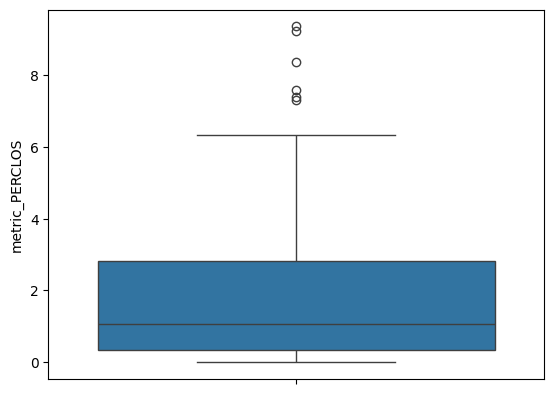

In [45]:
sns.boxplot(df_["metric_PERCLOS"])

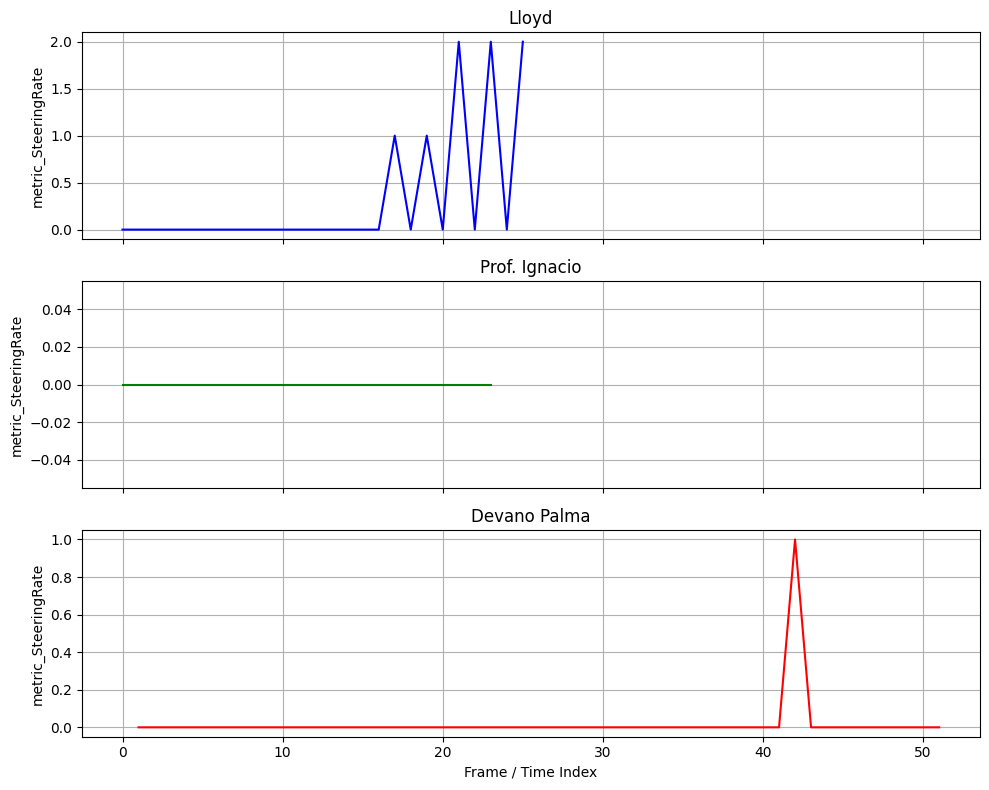

In [46]:
# Create subplots: 3 rows, 1 column (one plot per person)
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot each dataset on its own subplot
axes[0].plot(df2["metric_SteeringRate"], color='b')
axes[0].set_title('Lloyd')

axes[1].plot(df1["metric_SteeringRate"], color='g')
axes[1].set_title('Prof. Ignacio')

axes[2].plot(df3["metric_SteeringRate"], color='r')
axes[2].set_title('Devano Palma')

# Add labels and formatting
for ax in axes:
    ax.set_ylabel('metric_SteeringRate')
    ax.grid(True)

axes[-1].set_xlabel('Frame / Time Index')

plt.tight_layout()
plt.show()


In [47]:
df_

,window_id,metric_PERCLOS,metric_BlinkRate,blink_duration,metric_YawnRate,metric_Entropy,metric_SteeringRate,metric_SDLP,label
0,0,1.102088,8.352019,0.082657,0.0,0.089473,0.0,0.185746,Low
1,1,1.239437,8.103700,0.092958,0.0,0.044457,3.0,0.203346,Low
2,2,2.585722,14.156162,0.110817,0.0,0.053407,3.0,0.192183,Low
3,3,2.200903,13.193634,0.094324,0.0,0.053932,0.0,0.233520,Low
4,4,1.860203,11.165221,0.101466,0.0,0.019984,1.0,0.213990,Low
...,...,...,...,...,...,...,...,...,...
95,47,0.674157,6.071460,0.067416,0.0,0.092993,0.0,0.257945,Low
96,48,3.102087,9.134386,0.206806,0.0,0.060695,2.0,0.243620,Low
97,49,0.448179,5.037302,0.053782,0.0,0.135053,0.0,0.185180,Low
98,50,0.564653,6.096250,0.056465,0.0,0.071932,2.0,0.346109,Low


In [48]:
df_["label"].value_counts()

label
Low         62
Moderate    27
High        11
Name: count, dtype: int64

In [49]:
df_['label'] = df_['label'].map({'Low': 1, 'Moderate': 2, 'High': 3})

c:\temp\ipykernel_41176\2366518505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['label'] = df_['label'].map({'Low': 1, 'Moderate': 2, 'High': 3})


In [50]:
df_

,window_id,metric_PERCLOS,metric_BlinkRate,blink_duration,metric_YawnRate,metric_Entropy,metric_SteeringRate,metric_SDLP,label
0,0,1.102088,8.352019,0.082657,0.0,0.089473,0.0,0.185746,1
1,1,1.239437,8.103700,0.092958,0.0,0.044457,3.0,0.203346,1
2,2,2.585722,14.156162,0.110817,0.0,0.053407,3.0,0.192183,1
3,3,2.200903,13.193634,0.094324,0.0,0.053932,0.0,0.233520,1
4,4,1.860203,11.165221,0.101466,0.0,0.019984,1.0,0.213990,1
...,...,...,...,...,...,...,...,...,...
95,47,0.674157,6.071460,0.067416,0.0,0.092993,0.0,0.257945,1
96,48,3.102087,9.134386,0.206806,0.0,0.060695,2.0,0.243620,1
97,49,0.448179,5.037302,0.053782,0.0,0.135053,0.0,0.185180,1
98,50,0.564653,6.096250,0.056465,0.0,0.071932,2.0,0.346109,1


In [31]:
df_['label'].value_counts()

label
1    62
2    27
3    11
Name: count, dtype: int64

In [32]:
df_

,window_id,metric_PERCLOS,metric_BlinkRate,metric_YawnRate,metric_Entropy,metric_SteeringRate,metric_SDLP,label
0,0,1.102088,8.352019,0.0,0.089473,0.0,0.185746,1
1,1,1.239437,8.103700,0.0,0.044457,3.0,0.203346,1
2,2,2.585722,14.156162,0.0,0.053407,3.0,0.192183,1
3,3,2.200903,13.193634,0.0,0.053932,0.0,0.233520,1
4,4,1.860203,11.165221,0.0,0.019984,1.0,0.213990,1
...,...,...,...,...,...,...,...,...
95,47,0.674157,6.071460,0.0,0.092993,0.0,0.257945,1
96,48,3.102087,9.134386,0.0,0.060695,2.0,0.243620,1
97,49,0.448179,5.037302,0.0,0.135053,0.0,0.185180,1
98,50,0.564653,6.096250,0.0,0.071932,2.0,0.346109,1


In [52]:
df_rename_columns = {
    'metric_PERCLOS': 'perclos',
    'metric_BlinkRate': 'eye_blink_rate',
    'metric_YawnRate': 'yawning_rate',
    'metric_Entropy': 'steering_entropy',
    'metric_SteeringRate': 'steering_reversal_rate',
    'metric_SDLP': 'std_lane_position',
    'label': 'drowsiness_level'
}

df_ = df_.rename(columns=df_rename_columns, errors='ignore')


In [53]:
df_

,window_id,perclos,eye_blink_rate,blink_duration,yawning_rate,steering_entropy,steering_reversal_rate,std_lane_position,drowsiness_level
0,0,1.102088,8.352019,0.082657,0.0,0.089473,0.0,0.185746,1
1,1,1.239437,8.103700,0.092958,0.0,0.044457,3.0,0.203346,1
2,2,2.585722,14.156162,0.110817,0.0,0.053407,3.0,0.192183,1
3,3,2.200903,13.193634,0.094324,0.0,0.053932,0.0,0.233520,1
4,4,1.860203,11.165221,0.101466,0.0,0.019984,1.0,0.213990,1
...,...,...,...,...,...,...,...,...,...
95,47,0.674157,6.071460,0.067416,0.0,0.092993,0.0,0.257945,1
96,48,3.102087,9.134386,0.206806,0.0,0.060695,2.0,0.243620,1
97,49,0.448179,5.037302,0.053782,0.0,0.135053,0.0,0.185180,1
98,50,0.564653,6.096250,0.056465,0.0,0.071932,2.0,0.346109,1


In [54]:
df_.to_csv(r"C:\Users\pasupuleti\Desktop\group-project\experiments\drowsiness_data\drowsiness_dataset_cleaned.csv", index=False)

In [55]:
df_["drowsiness_level"].value_counts()

drowsiness_level
1    62
2    27
3    11
Name: count, dtype: int64

In [59]:
filtered_df = df_[df_["drowsiness_level"].isin([2, 3])]

In [60]:
filtered_df

,window_id,perclos,eye_blink_rate,blink_duration,yawning_rate,steering_entropy,steering_reversal_rate,std_lane_position,drowsiness_level
7,7,6.330532,26.198837,0.146089,0.0,0.050368,2.0,0.180120,2
10,10,5.449438,23.266271,0.142159,0.0,0.072649,0.0,0.196146,2
12,12,3.923767,17.129694,0.138486,0.0,0.047933,2.0,0.195798,2
13,13,7.580011,27.303104,0.168445,0.0,0.102520,1.0,0.212769,2
14,14,5.892256,24.203669,0.147306,0.0,0.202280,0.0,0.226266,2
15,16,5.693348,23.273856,0.148522,0.0,0.041309,3.0,0.279376,2
16,17,5.783268,27.264080,0.128517,0.0,0.058710,3.0,0.198437,2
17,18,7.399103,22.200189,0.201794,0.0,0.077136,0.0,0.283560,2
18,19,9.352113,19.246699,0.295330,0.0,0.026185,2.0,0.247797,3
19,20,7.295174,24.229796,0.182379,0.0,0.057545,2.0,0.291838,2


c:\temp\ipykernel_41176\1381986425.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="drowsiness_level", y="perclos", data=df_, palette="viridis")
c:\temp\ipykernel_41176\1381986425.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="drowsiness_level", y="eye_blink_rate", data=df_, palette="viridis")
c:\temp\ipykernel_41176\1381986425.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="drowsiness_level", y="blink_duration", data=df_, palette="viridis")


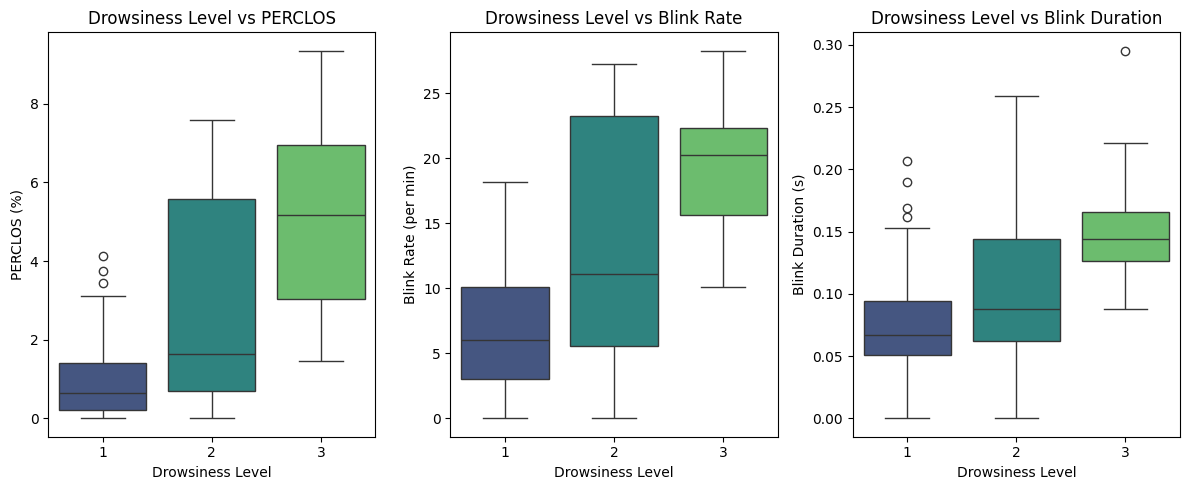

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume your DataFrame is named df
# and has columns: "drowsiness_level", "perclos", "blink_rate", "blink_duration"

plt.figure(figsize=(12, 5))

# 1️⃣ PERCLOS
plt.subplot(1, 3, 1)
sns.boxplot(x="drowsiness_level", y="perclos", data=df_, palette="viridis")
plt.title("Drowsiness Level vs PERCLOS")
plt.xlabel("Drowsiness Level")
plt.ylabel("PERCLOS (%)")

# 2️⃣ Blink Rate
plt.subplot(1, 3, 2)
sns.boxplot(x="drowsiness_level", y="eye_blink_rate", data=df_, palette="viridis")
plt.title("Drowsiness Level vs Blink Rate")
plt.xlabel("Drowsiness Level")
plt.ylabel("Blink Rate (per min)")

# 3️⃣ Blink Duration
plt.subplot(1, 3, 3)
sns.boxplot(x="drowsiness_level", y="blink_duration", data=df_, palette="viridis")
plt.title("Drowsiness Level vs Blink Duration")
plt.xlabel("Drowsiness Level")
plt.ylabel("Blink Duration (s)")

plt.tight_layout()
plt.show()


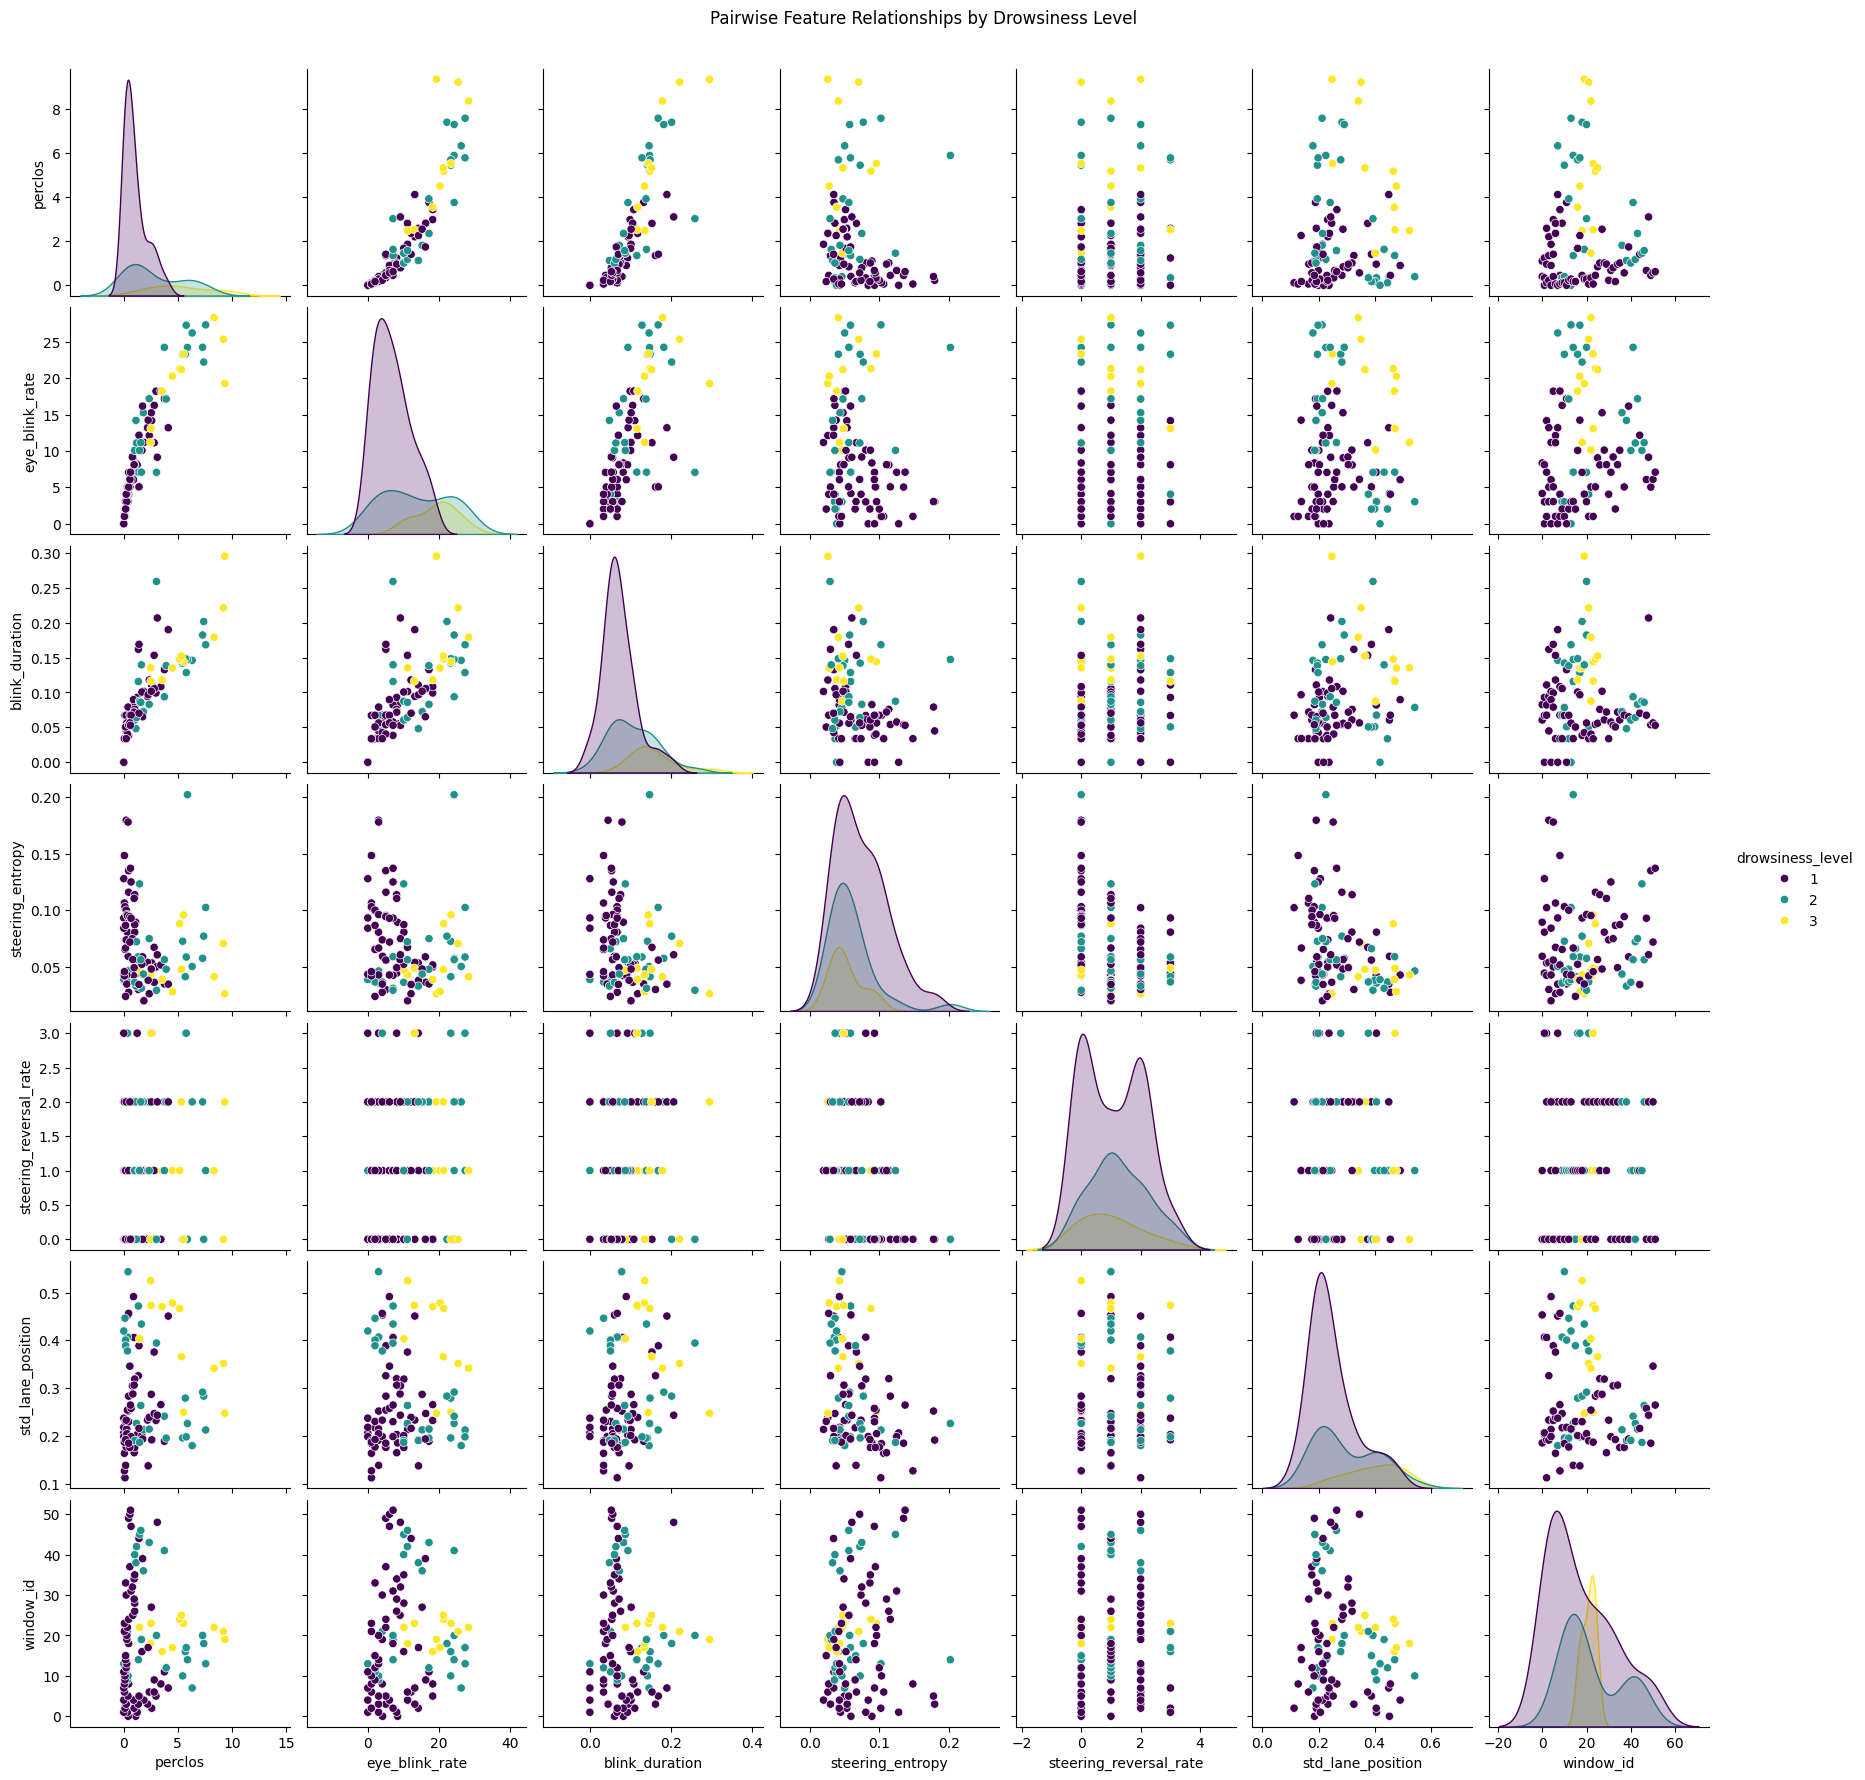

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# choose the features that matter
features = [
    "perclos", 
    "eye_blink_rate", 
    "blink_duration", 
    "steering_entropy", 
    "steering_reversal_rate", 
    "std_lane_position", 
    "window_id"
]

sns.pairplot(df_[features + ["drowsiness_level"]], hue="drowsiness_level", palette="viridis")
plt.suptitle("Pairwise Feature Relationships by Drowsiness Level", y=1.02)
plt.show()


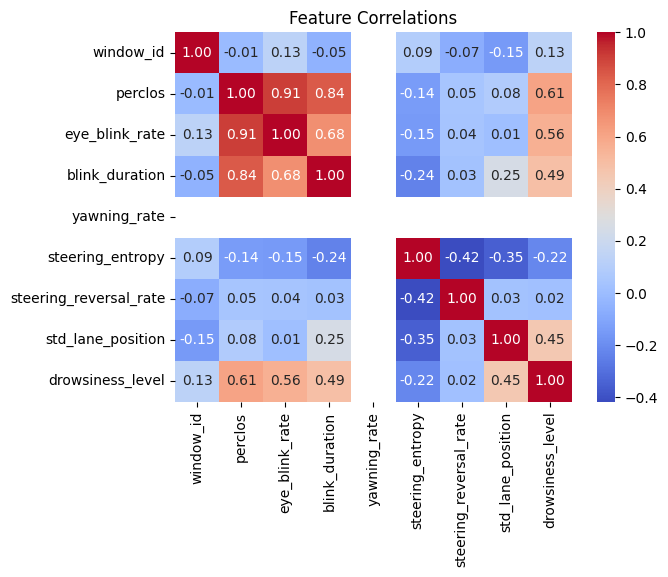

In [65]:
sns.heatmap(df_.corr(numeric_only=True),annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Feature Correlations")
plt.show()

In [66]:
df_

,window_id,perclos,eye_blink_rate,blink_duration,yawning_rate,steering_entropy,steering_reversal_rate,std_lane_position,drowsiness_level
0,0,1.102088,8.352019,0.082657,0.0,0.089473,0.0,0.185746,1
1,1,1.239437,8.103700,0.092958,0.0,0.044457,3.0,0.203346,1
2,2,2.585722,14.156162,0.110817,0.0,0.053407,3.0,0.192183,1
3,3,2.200903,13.193634,0.094324,0.0,0.053932,0.0,0.233520,1
4,4,1.860203,11.165221,0.101466,0.0,0.019984,1.0,0.213990,1
...,...,...,...,...,...,...,...,...,...
95,47,0.674157,6.071460,0.067416,0.0,0.092993,0.0,0.257945,1
96,48,3.102087,9.134386,0.206806,0.0,0.060695,2.0,0.243620,1
97,49,0.448179,5.037302,0.053782,0.0,0.135053,0.0,0.185180,1
98,50,0.564653,6.096250,0.056465,0.0,0.071932,2.0,0.346109,1


In [84]:
# ===============================================
# Driver Drowsiness Detection using Random Forest
# ===============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ===============================
# 1. Load and Prepare the Dataset

# Define feature columns (update as per your dataset)
feature_cols = [
    "perclos",
    "eye_blink_rate",
    "blink_duration",
    "steering_entropy",
    "steering_reversal_rate",
    "std_lane_position",
    "window_id"
]

target_col = "drowsiness_level"

X = df_[feature_cols]
y = df_[target_col]

# ===============================
# 2. Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ===============================
# 3. Random Forest Model
# ===============================
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=200,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
)

rf.fit(X_train, y_train)

# ===============================
# 4. Evaluation
# ===============================
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8333333333333334

Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.95      0.88        19
           2       0.80      0.50      0.62         8
           3       1.00      1.00      1.00         3

    accuracy                           0.83        30
   macro avg       0.87      0.82      0.83        30
weighted avg       0.83      0.83      0.82        30



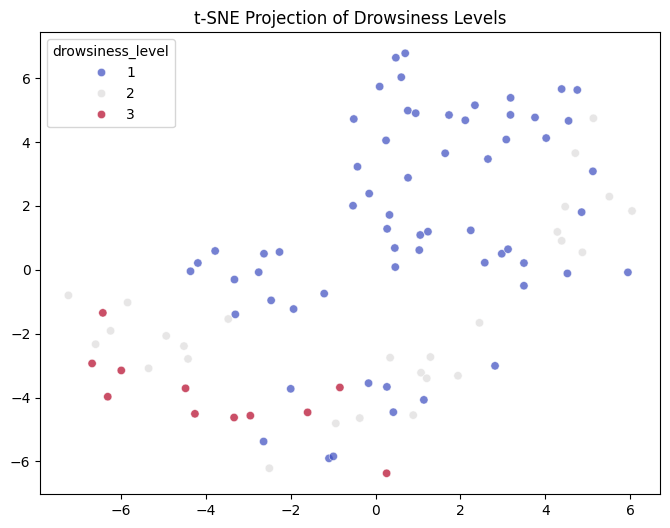

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = df_[features]
y = df_['drowsiness_level']

# Normalize
X_scaled = StandardScaler().fit_transform(X)

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='coolwarm', alpha=0.7)
plt.title("t-SNE Projection of Drowsiness Levels")
plt.show()


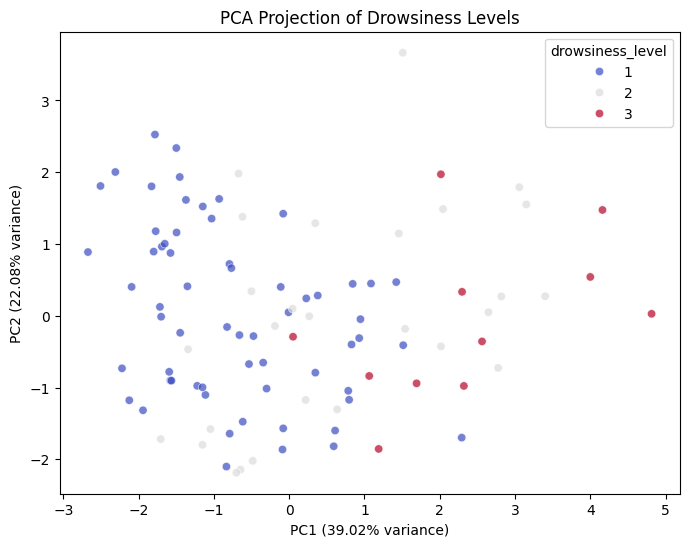

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Features and labels
X = df_[features]
y = df_['drowsiness_level']

# Normalize
X_scaled = StandardScaler().fit_transform(X)

# PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm', alpha=0.7)
plt.title("PCA Projection of Drowsiness Levels")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
plt.show()

In [97]:
import pandas as pd

# Assuming df_ is your DataFrame
df_ = df_.reset_index(drop=True)

# Find indices where window_id resets (new participant starts)
reset_points = df_[df_['window_id'].diff() < 0].index.tolist()

# Add the start (0) and end of DataFrame as boundaries
split_indices = [0] + reset_points + [len(df_)]

# Split into separate DataFrames
dfs = []
for i in range(len(split_indices) - 1):
    df_part = df_.iloc[split_indices[i]:split_indices[i+1]].reset_index(drop=True)
    dfs.append(df_part)
    print(f"Participant {i+1}: {len(df_part)} samples, window_id range {df_part['window_id'].min()}–{df_part['window_id'].max()}")

# Access each participant’s data
df_person1, df_person2, df_person3 = dfs


Participant 1: 23 samples, window_id range 0–23
Participant 2: 26 samples, window_id range 0–25
Participant 3: 51 samples, window_id range 1–51


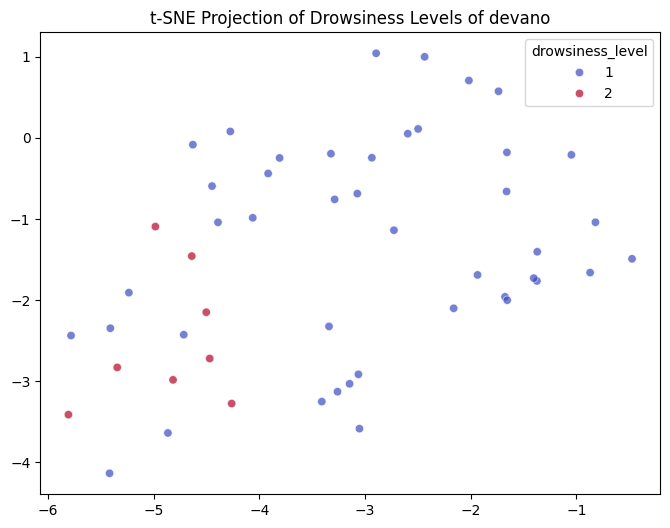

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = df_person3[features]
y = df_person3['drowsiness_level']

# Normalize
X_scaled = StandardScaler().fit_transform(X)

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='coolwarm', alpha=0.7)
plt.title("t-SNE Projection of Drowsiness Levels of devano")
plt.show()

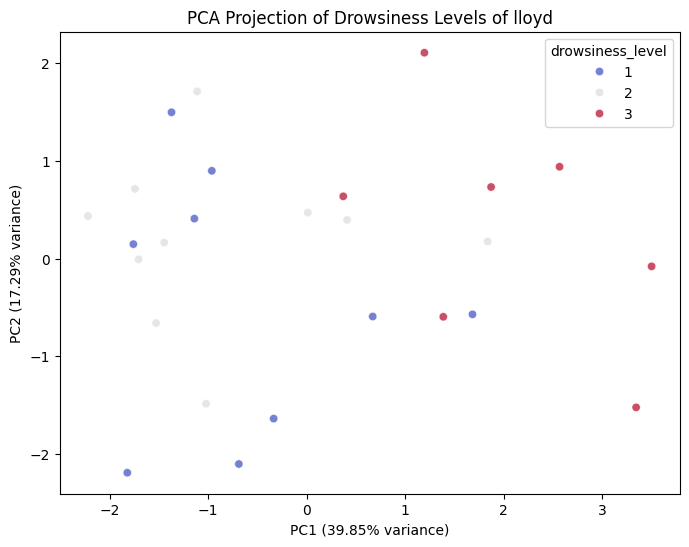

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Features and labels
X = df_person2[features]
y = df_person2['drowsiness_level']

# Normalize
X_scaled = StandardScaler().fit_transform(X)

# PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm', alpha=0.7)
plt.title("PCA Projection of Drowsiness Levels of lloyd")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
plt.show()

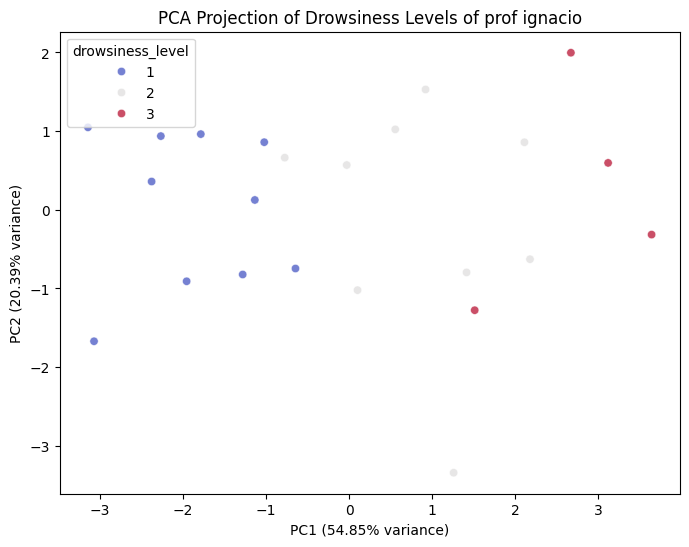

In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Features and labels
X = df_person1[features]
y = df_person1['drowsiness_level']

# Normalize
X_scaled = StandardScaler().fit_transform(X)

# PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm', alpha=0.7)
plt.title("PCA Projection of Drowsiness Levels of prof ignacio")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
plt.show()

In [ ]:
# assuming your dataframe is called df_ and label column is 'drowsiness_level'

# extract 2 random samples per label
df_fewshot = (
    df_person1
    .groupby('drowsiness_level', group_keys=False)
    .apply(lambda x: x.sample(n=2, random_state=42))
    .reset_index(drop=True)
)
df_fewshot


c:\temp\ipykernel_41176\3156488268.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=2, random_state=42))


,window_id,perclos,eye_blink_rate,blink_duration,yawning_rate,steering_entropy,steering_reversal_rate,std_lane_position,drowsiness_level
0,9,2.816901,16.253268,0.105634,0.0,0.036320,1.0,0.247149,1
1,1,1.239437,8.103700,0.092958,0.0,0.044457,3.0,0.203346,1
2,18,7.399103,22.200189,0.201794,0.0,0.077136,0.0,0.283560,2
3,10,5.449438,23.266271,0.142159,0.0,0.072649,0.0,0.196146,2
4,21,9.218662,25.330645,0.221248,0.0,0.070656,0.0,0.351883,3
5,23,5.524239,23.329104,0.144111,0.0,0.095920,0.0,0.249673,3


In [112]:
# assuming your dataframe is called df_ and label column is 'drowsiness_level'

# extract 2 random samples per label
df_fewshot = (
    df_person2
    .groupby('drowsiness_level', group_keys=False)
    .apply(lambda x: x.sample(n=2, random_state=42))
    .reset_index(drop=True)
)

df_fewshot


c:\temp\ipykernel_41176\685301075.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=2, random_state=42))


,window_id,perclos,eye_blink_rate,blink_duration,yawning_rate,steering_entropy,steering_reversal_rate,std_lane_position,drowsiness_level
0,7,4.117315,13.184026,0.190030,0.0,0.034691,2.0,0.450781,1
1,1,0.335383,3.012050,0.067077,0.0,0.080695,3.0,0.406739,1
2,20,3.023516,7.060079,0.259159,0.0,0.029311,0.0,0.394416,2
3,10,0.392817,3.026193,0.078563,0.0,0.046387,1.0,0.543490,2
4,16,3.545301,18.214495,0.118177,0.0,0.038876,1.0,0.470451,3
5,17,4.501970,20.256999,0.135059,0.0,0.028081,1.0,0.478071,3


In [116]:
# assuming your dataframe is called df_ and label column is 'drowsiness_level'

# extract 2 random samples per label
df_fewshot = (
    df_person3
    .groupby('drowsiness_level', group_keys=False)
    .apply(lambda x: x.sample(n=2, random_state=4))
    .reset_index(drop=True)
)

df_fewshot


c:\temp\ipykernel_41176\3793302085.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=2, random_state=4))


,window_id,perclos,eye_blink_rate,blink_duration,yawning_rate,steering_entropy,steering_reversal_rate,std_lane_position,drowsiness_level
0,32,0.793201,9.171919,0.052880,0.0,0.074944,2.0,0.304989,1
1,51,0.618325,7.082232,0.052999,0.0,0.137200,0.0,0.264831,1
2,42,1.175812,11.095284,0.064135,0.0,0.072219,0.0,0.226402,2
3,46,1.574803,11.140262,0.085898,0.0,0.056275,2.0,0.263955,2
